In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# loading and preprocessing data
data = pd.read_json("Amazon_Fashion.jsonl", lines=True)

In [3]:
data = data[data["rating"] != 3]

In [4]:
data = data[data["timestamp"] > "2015-01-01"]

In [5]:
data["year"] = data["timestamp"].apply(lambda x: x.year)
data["month"] = data["timestamp"].apply(lambda x: x.month)
data["day"] = data["timestamp"].apply(lambda x: x.day)

In [6]:
# binarization of reviews to train ctr-predictor
data["rating"] = data["rating"].transform(lambda x: 1 if x > 3 else 0)

In [7]:
data.set_index(data["timestamp"], inplace=True)

In [8]:
data.sort_index(inplace=True)

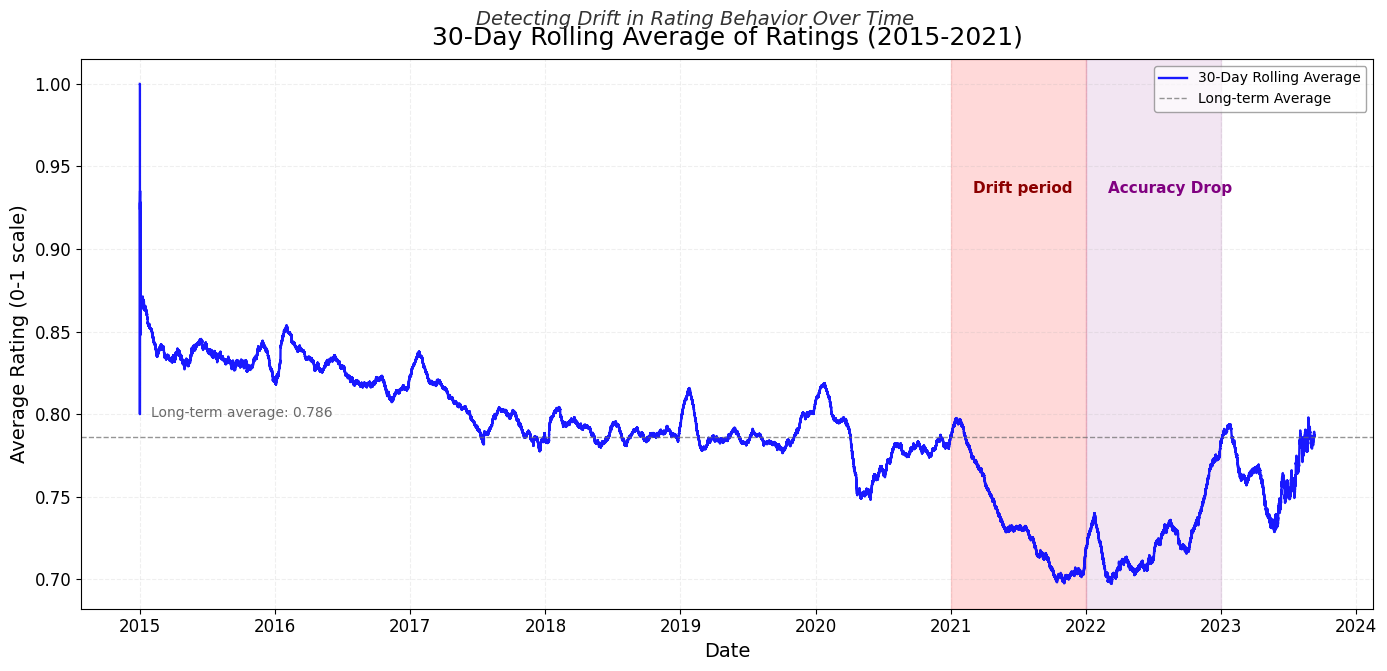

In [9]:
# # Set style to white background instead of dark
plt.style.use("default")  # Using default style for white background

# Create figure and axis with adjusted size for better layout
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the 30-day rolling average with thinner line
rolling_avg = data["rating"].rolling("30D").mean()
ax.plot(rolling_avg.index, rolling_avg, color="blue", linewidth=1.7, alpha=0.9)

# Calculate and add long-term average reference line
long_term_avg = data["rating"].mean()
ax.axhline(y=long_term_avg, color="dimgray", linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    data.index.min() + pd.Timedelta(days=30),
    long_term_avg + 0.01,
    f"Long-term average: {long_term_avg:.3f}",
    color="dimgray",
    fontsize=10,
    verticalalignment="bottom",
)

# Add shaded region to mark drift period
drift_start = pd.Timestamp("2021-01-01")
drift_end = pd.Timestamp("2022-01-01")  # Assuming drift period extends to 2022
ax.axvspan(drift_start, drift_end, color="red", alpha=0.15)
ax.text(
    drift_start + pd.Timedelta(days=60),
    ax.get_ylim()[1] * 0.92,
    "Drift period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)


# Highlight accuracy drop period (2022 to 2023)
drop_start = pd.Timestamp("2022-01-01")
drop_end = pd.Timestamp("2023-01-01")
ax.axvspan(drop_start, drop_end, color="purple", alpha=0.1)
ax.text(
    drop_start + pd.Timedelta(days=60),
    ax.get_ylim()[1] * 0.92,
    "Accuracy Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)


# Add title and subtitle with increased font sizes
ax.set_title(
    "30-Day Rolling Average of Ratings (2015-2021)", fontsize=18, pad=10, color="black"
)
plt.figtext(
    0.5,
    0.93,
    "Detecting Drift in Rating Behavior Over Time",
    ha="center",
    fontsize=14,
    style="italic",
    color="#333333",
)

# Add labels with increased font sizes
ax.set_xlabel("Date", fontsize=14, color="black")
ax.set_ylabel("Average Rating (0-1 scale)", fontsize=14, color="black")

# Format x-axis to show only year markers to reduce clutter
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(fontsize=12, color="black")
plt.yticks(fontsize=12, color="black")

# Improve legend styling for white background
legend = ax.legend(
    ["30-Day Rolling Average", "Long-term Average"],
    loc="upper right",
    fontsize=10,
    framealpha=0.7,
    edgecolor="gray",
    facecolor="white",
)

# Add grid for better readability
ax.grid(True, linestyle="--", alpha=0.2)

# Ensure layout is tight with no overlaps
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for subtitle

plt.savefig("rolling_average_plot.png", dpi=300, bbox_inches="tight", facecolor="white")
# Display the plot
plt.show()

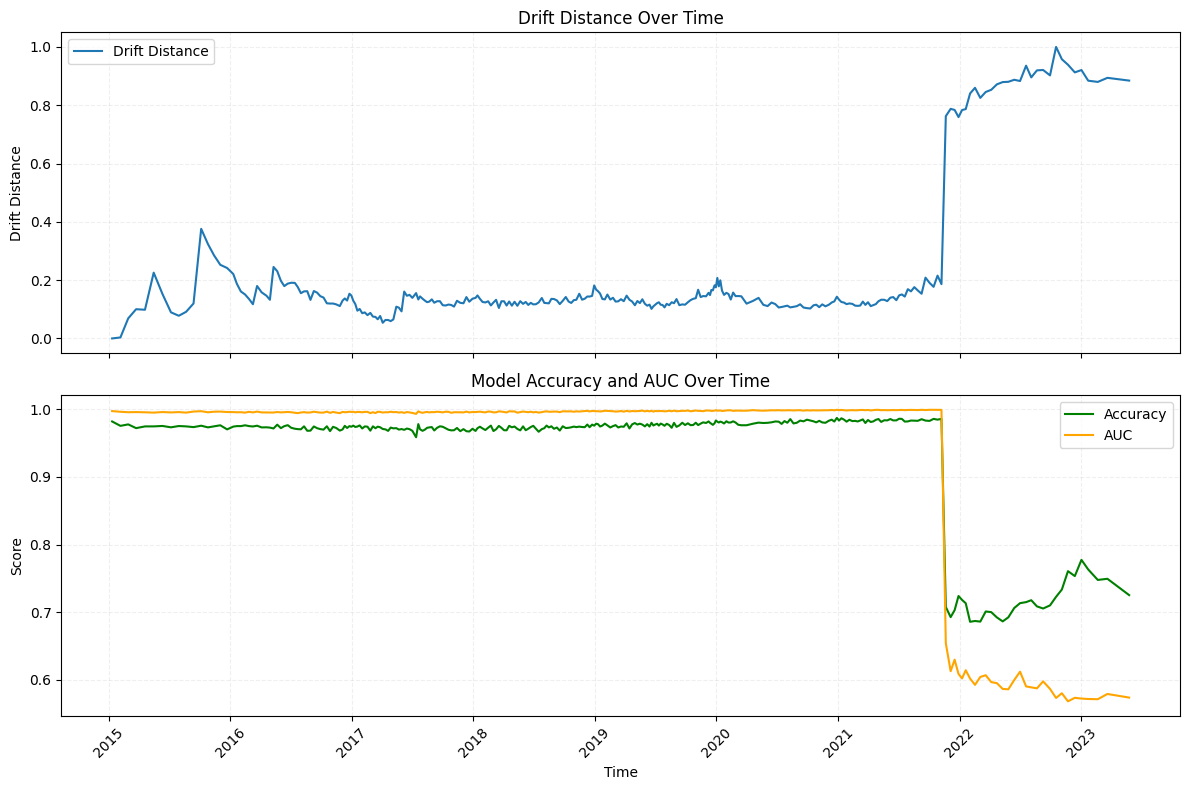

In [10]:
# Load the new CSV file
file_path_mmd = "/baseline-experiment/baseline_results/2025-04-05_09-13-45/drift_detection_results_mmd_histogram.csv"
df_mmd = pd.read_csv(file_path_mmd)

# Convert window_time to datetime
df_mmd["window_time"] = pd.to_datetime(df_mmd["window_time"])

# Normalize drift distance to 0-1 scale
df_mmd["drift_distance"] = (
    df_mmd["drift_distance"] - df_mmd["drift_distance"].min()
) / (df_mmd["drift_distance"].max() - df_mmd["drift_distance"].min())

# Set up the plot
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot normalized drift distance
axs[0].plot(df_mmd["window_time"], df_mmd["drift_distance"], label="Drift Distance")
axs[0].set_ylabel("Drift Distance")
axs[0].set_title("Drift Distance Over Time")
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.2)


# Plot accuracy and AUC on the same plot
axs[1].plot(df_mmd["window_time"], df_mmd["accuracy"], color="green", label="Accuracy")
axs[1].plot(df_mmd["window_time"], df_mmd["auc"], color="orange", label="AUC")
axs[1].set_ylabel("Score")
axs[1].set_title("Model Accuracy and AUC Over Time")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.2)

# Formatting the x-axis
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    "drift_detection_results_mmd_histogram.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

In [11]:
import os
from glob import glob

import pandas as pd

# Set your directory path here
directory = "/Users/jasper.bruin/Documents/driftwatch/driftwatch/baseline-experiment/baseline_results/2025-04-05_09-13-45"

# Pattern to match files
file_pattern = os.path.join(directory, "drift_detection_results_*.csv")

# List all matching files
file_list = glob(file_pattern)

# Load and combine files
all_dfs = []
for file_path in file_list:
    df = pd.read_csv(file_path)
    method = (
        os.path.basename(file_path)
        .replace("drift_detection_results_", "")
        .replace(".csv", "")
    )
    df["method"] = method
    all_dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)

# Convert time if needed
combined_df["window_time"] = pd.to_datetime(combined_df["window_time"])

# Optional: Save to a new CSV
combined_df.to_csv("combined_drift_detection_results.csv", index=False)

In [12]:
combined_df

,window_time,drift_distance,threshold,drift_detected,accuracy,auc,method
0,2015-01-11 08:09:48.506820096,0.000000,0.018653,0,0.982081,0.997392,bhattacharyya_histogram
1,2015-02-05 05:45:21.200667648,0.002953,0.018653,0,0.975567,0.996395,bhattacharyya_histogram
2,2015-02-28 16:39:17.016885504,0.009618,0.018653,0,0.977754,0.995738,bhattacharyya_histogram
3,2015-03-24 08:51:32.283909632,0.013173,0.018653,0,0.972207,0.995922,bhattacharyya_histogram
4,2015-04-19 23:55:22.089075712,0.013299,0.018653,0,0.974760,0.995622,bhattacharyya_histogram
...,...,...,...,...,...,...,...
5395,2023-01-01 16:50:34.107695360,0.026632,0.037495,0,0.777524,0.572518,wasserstein_histogram
5396,2023-01-21 22:36:39.085148160,0.025938,0.036496,0,0.763360,0.571895,wasserstein_histogram
5397,2023-02-19 18:52:46.886860032,0.025502,0.034980,0,0.747860,0.571576,wasserstein_histogram
5398,2023-03-20 16:48:23.729529344,0.025473,0.032835,0,0.749561,0.579305,wasserstein_histogram


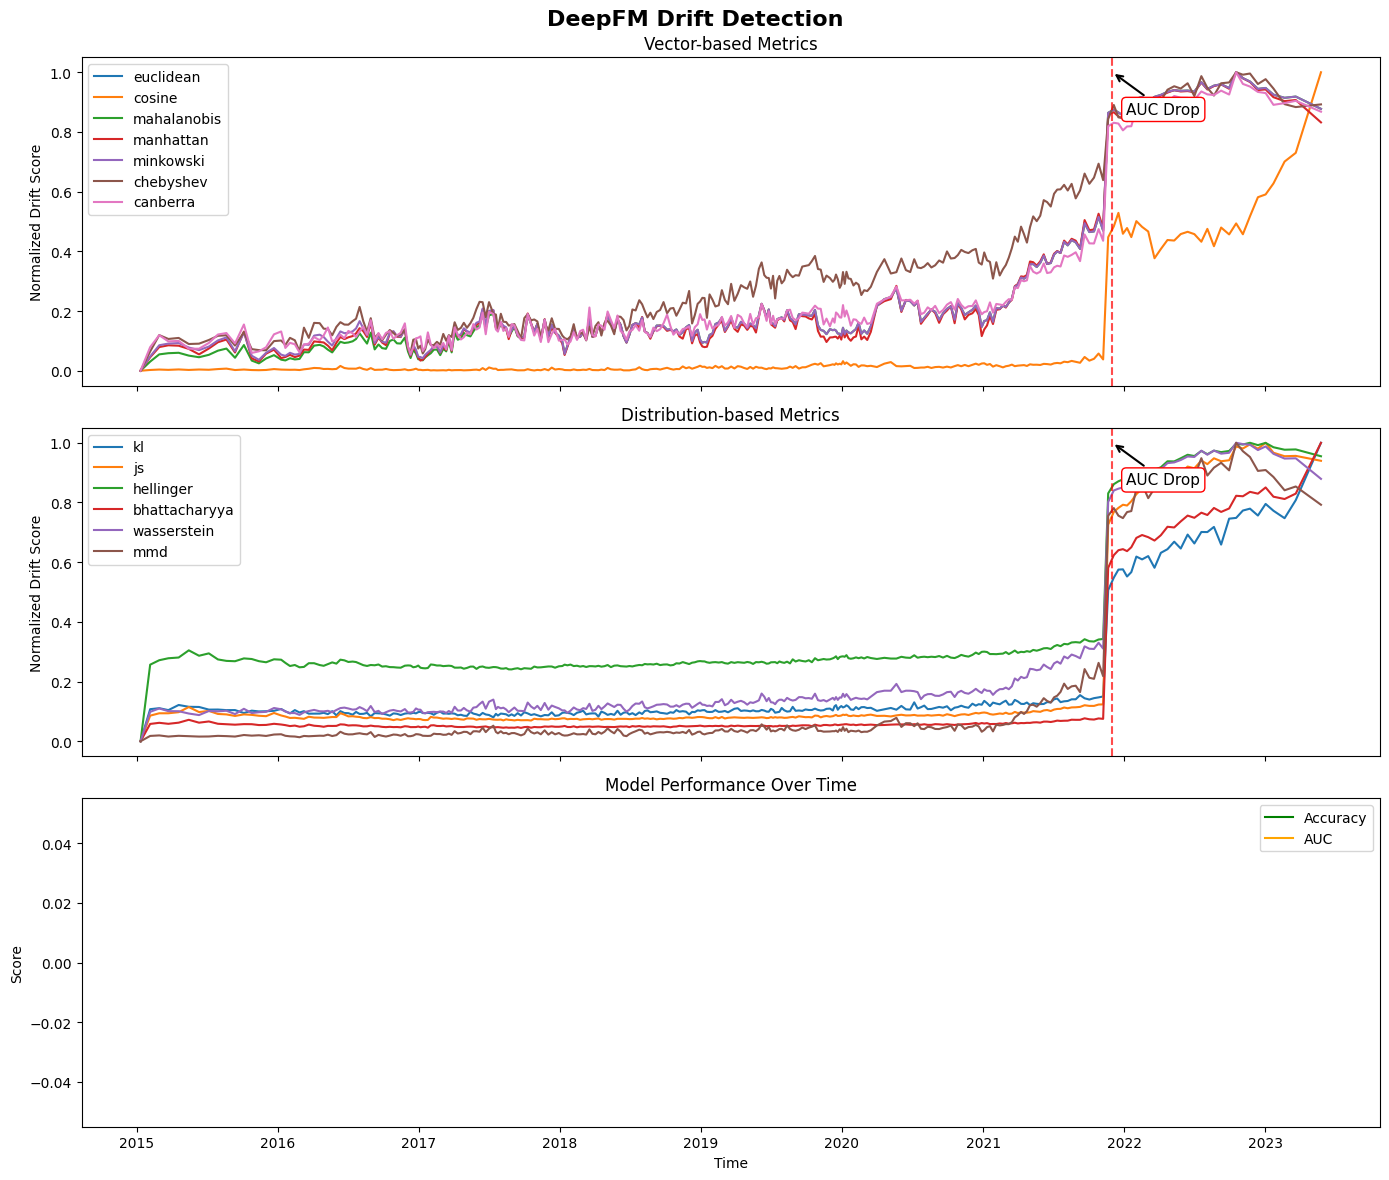

In [13]:
import matplotlib.pyplot as plt

# Make a copy to safely modify
merged_df = combined_df.copy()

# Define merging of histogram and kll into unified labels
merge_map = {
    "kl_kll": "kl",
    "kl_histogram": "kl",
    "js_kll": "js",
    "js_histogram": "js",
    "hellinger_kll": "hellinger",
    "hellinger_histogram": "hellinger",
    "bhattacharyya_kll": "bhattacharyya",
    "bhattacharyya_histogram": "bhattacharyya",
    "wasserstein_kll": "wasserstein",  # no histogram version here
    "mmd_kll": "mmd",  # no histogram version here
}

# Merge method names
merged_df["method"] = merged_df["method"].replace(merge_map)

# Group by method and time, averaging drift values
merged_df = merged_df.groupby(["method", "window_time"], as_index=False).mean()

# Normalize per method
merged_df["normalized_drift"] = merged_df.groupby("method")["drift_distance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Update method categories
vector_methods = [
    "euclidean",
    "cosine",
    "mahalanobis",
    "manhattan",
    "minkowski",
    "chebyshev",
    "canberra",
]
distribution_methods = ["kl", "js", "hellinger", "bhattacharyya", "wasserstein", "mmd"]

# Get AUC drop info from 2022
performance_df = merged_df[merged_df["method"] == "euclidean"]
drop_point = performance_df[performance_df["window_time"].dt.year == 2022]
if not drop_point.empty:
    auc_2022 = drop_point.iloc[0]["auc"]
    time_2022 = pd.to_datetime("2021-12-01")
    auc_annotation = f"AUC ↓ {auc_2022:.2f}"
else:
    # Fallback if no data found at 2022
    time_2022 = pd.to_datetime("2021-12-01")
    auc_annotation = "AUC Drop"

# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle("DeepFM Drift Detection", fontsize=16, fontweight="bold")

# Panel 1: Vector-based
for method in vector_methods:
    subset = merged_df[merged_df["method"] == method]
    axs[0].plot(subset["window_time"], subset["normalized_drift"], label=method)
axs[0].axvline(x=time_2022, color="red", linestyle="--", alpha=0.7)
axs[0].annotate(
    auc_annotation,
    xy=(time_2022, 1),
    xycoords="data",
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=1.5),
    fontsize=11,
    color="black",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1),
)
axs[0].set_title("Vector-based Metrics")
axs[0].set_ylabel("Normalized Drift Score")
axs[0].legend()

# Panel 2: Distribution-based
for method in distribution_methods:
    subset = merged_df[merged_df["method"] == method]
    axs[1].plot(subset["window_time"], subset["normalized_drift"], label=method)
axs[1].axvline(x=time_2022, color="red", linestyle="--", alpha=0.7)
axs[1].annotate(
    auc_annotation,
    xy=(time_2022, 1),
    xycoords="data",
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=1.5),
    fontsize=11,
    color="black",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1),
)
axs[1].set_title("Distribution-based Metrics")
axs[1].set_ylabel("Normalized Drift Score")
axs[1].legend()


# Panel 3: AUC and Accuracy (from any one method, e.g., 'euclidean')
performance_df = merged_df[merged_df["method"] == "euclidean"]
axs[2].plot(
    performance_df["window_time"],
    performance_df["accuracy"],
    label="Accuracy",
    color="green",
)
axs[2].plot(
    performance_df["window_time"], performance_df["auc"], label="AUC", color="orange"
)
axs[2].set_title("Model Performance Over Time")
axs[2].set_ylabel("Score")
axs[2].set_xlabel("Time")
axs[2].legend()

plt.tight_layout()
plt.show()

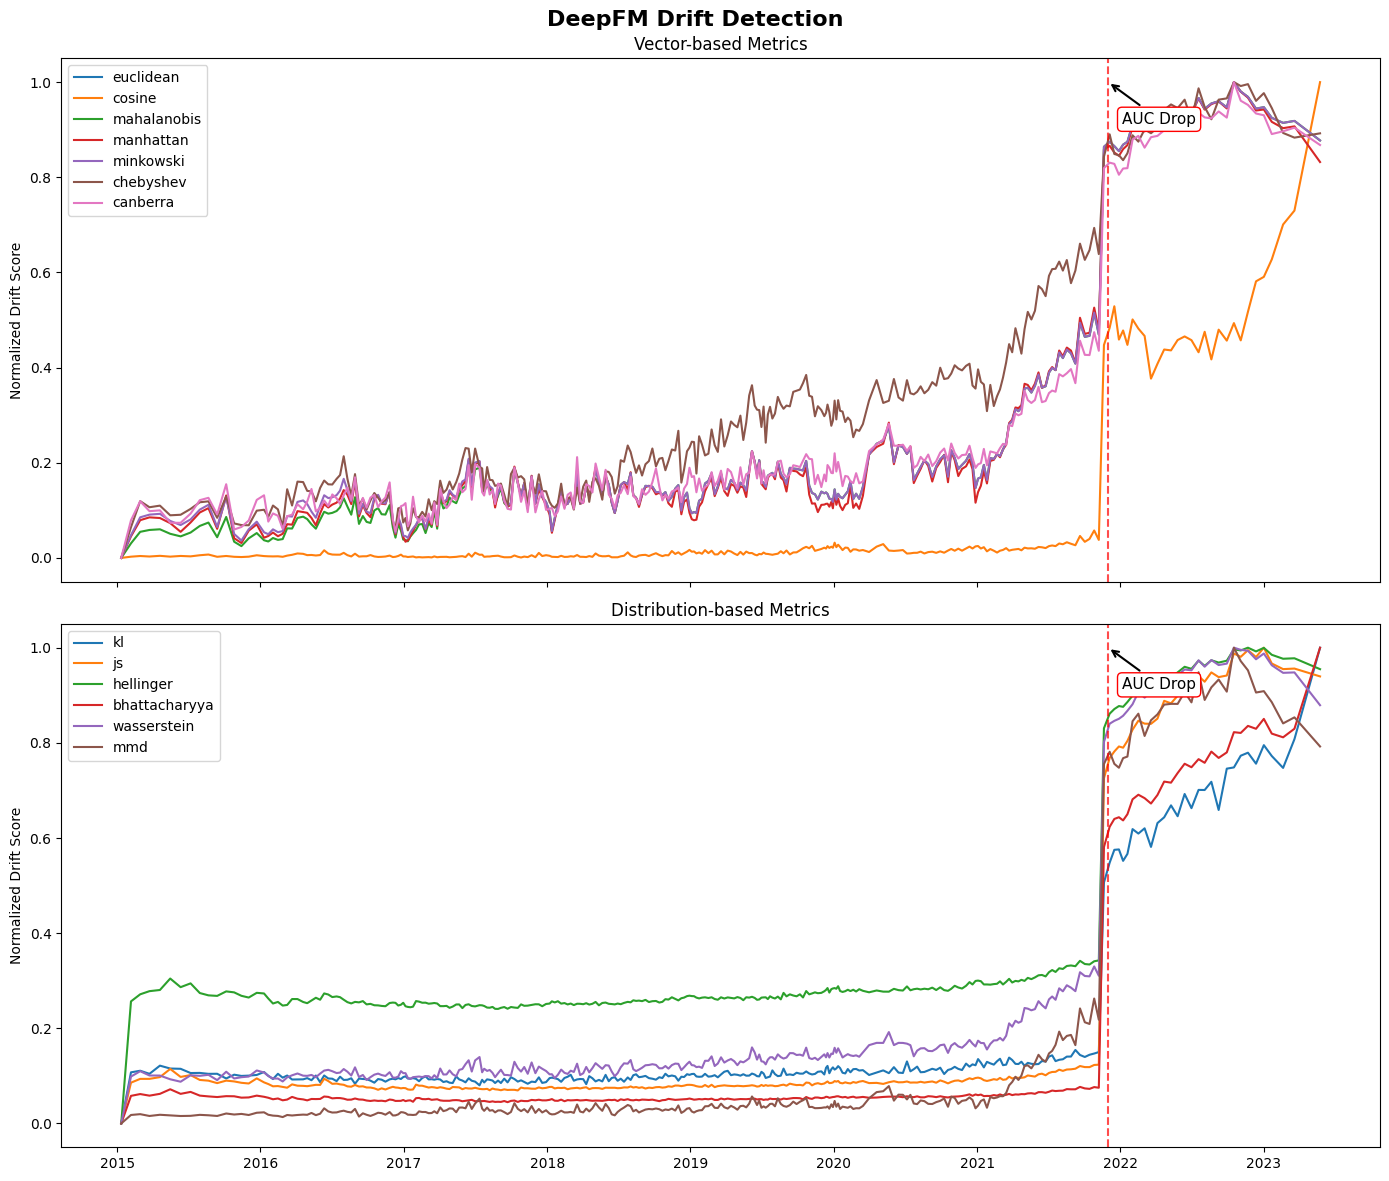

In [14]:
import matplotlib.pyplot as plt

# Make a copy to safely modify
merged_df = combined_df.copy()

# Define merging of histogram and kll into unified labels
merge_map = {
    "kl_kll": "kl",
    "kl_histogram": "kl",
    "js_kll": "js",
    "js_histogram": "js",
    "hellinger_kll": "hellinger",
    "hellinger_histogram": "hellinger",
    "bhattacharyya_kll": "bhattacharyya",
    "bhattacharyya_histogram": "bhattacharyya",
    "wasserstein_kll": "wasserstein",  # no histogram version here
    "mmd_kll": "mmd",  # no histogram version here
}

# Merge method names
merged_df["method"] = merged_df["method"].replace(merge_map)

# Group by method and time, averaging drift values
merged_df = merged_df.groupby(["method", "window_time"], as_index=False).mean()

# Normalize per method
merged_df["normalized_drift"] = merged_df.groupby("method")["drift_distance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Update method categories
vector_methods = [
    "euclidean",
    "cosine",
    "mahalanobis",
    "manhattan",
    "minkowski",
    "chebyshev",
    "canberra",
]
distribution_methods = ["kl", "js", "hellinger", "bhattacharyya", "wasserstein", "mmd"]

# Get AUC drop info from 2022
performance_df = merged_df[merged_df["method"] == "euclidean"]
drop_point = performance_df[performance_df["window_time"].dt.year == 2022]
if not drop_point.empty:
    auc_2022 = drop_point.iloc[0]["auc"]
    time_2022 = pd.to_datetime("2021-12-01")
    auc_annotation = f"AUC ↓ {auc_2022:.2f}"
else:
    # Fallback if no data found at 2022
    time_2022 = pd.to_datetime("2021-12-01")
    auc_annotation = "AUC Drop"

# Set up the plot
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle("DeepFM Drift Detection", fontsize=16, fontweight="bold")

# Panel 1: Vector-based
for method in vector_methods:
    subset = merged_df[merged_df["method"] == method]
    axs[0].plot(subset["window_time"], subset["normalized_drift"], label=method)
axs[0].axvline(x=time_2022, color="red", linestyle="--", alpha=0.7)
axs[0].annotate(
    auc_annotation,
    xy=(time_2022, 1),
    xycoords="data",
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=1.5),
    fontsize=11,
    color="black",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1),
)
axs[0].set_title("Vector-based Metrics")
axs[0].set_ylabel("Normalized Drift Score")
axs[0].legend()

# Panel 2: Distribution-based
for method in distribution_methods:
    subset = merged_df[merged_df["method"] == method]
    axs[1].plot(subset["window_time"], subset["normalized_drift"], label=method)
axs[1].axvline(x=time_2022, color="red", linestyle="--", alpha=0.7)
axs[1].annotate(
    auc_annotation,
    xy=(time_2022, 1),
    xycoords="data",
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=1.5),
    fontsize=11,
    color="black",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1),
)
axs[1].set_title("Distribution-based Metrics")
axs[1].set_ylabel("Normalized Drift Score")
axs[1].legend()

plt.tight_layout()
plt.show()

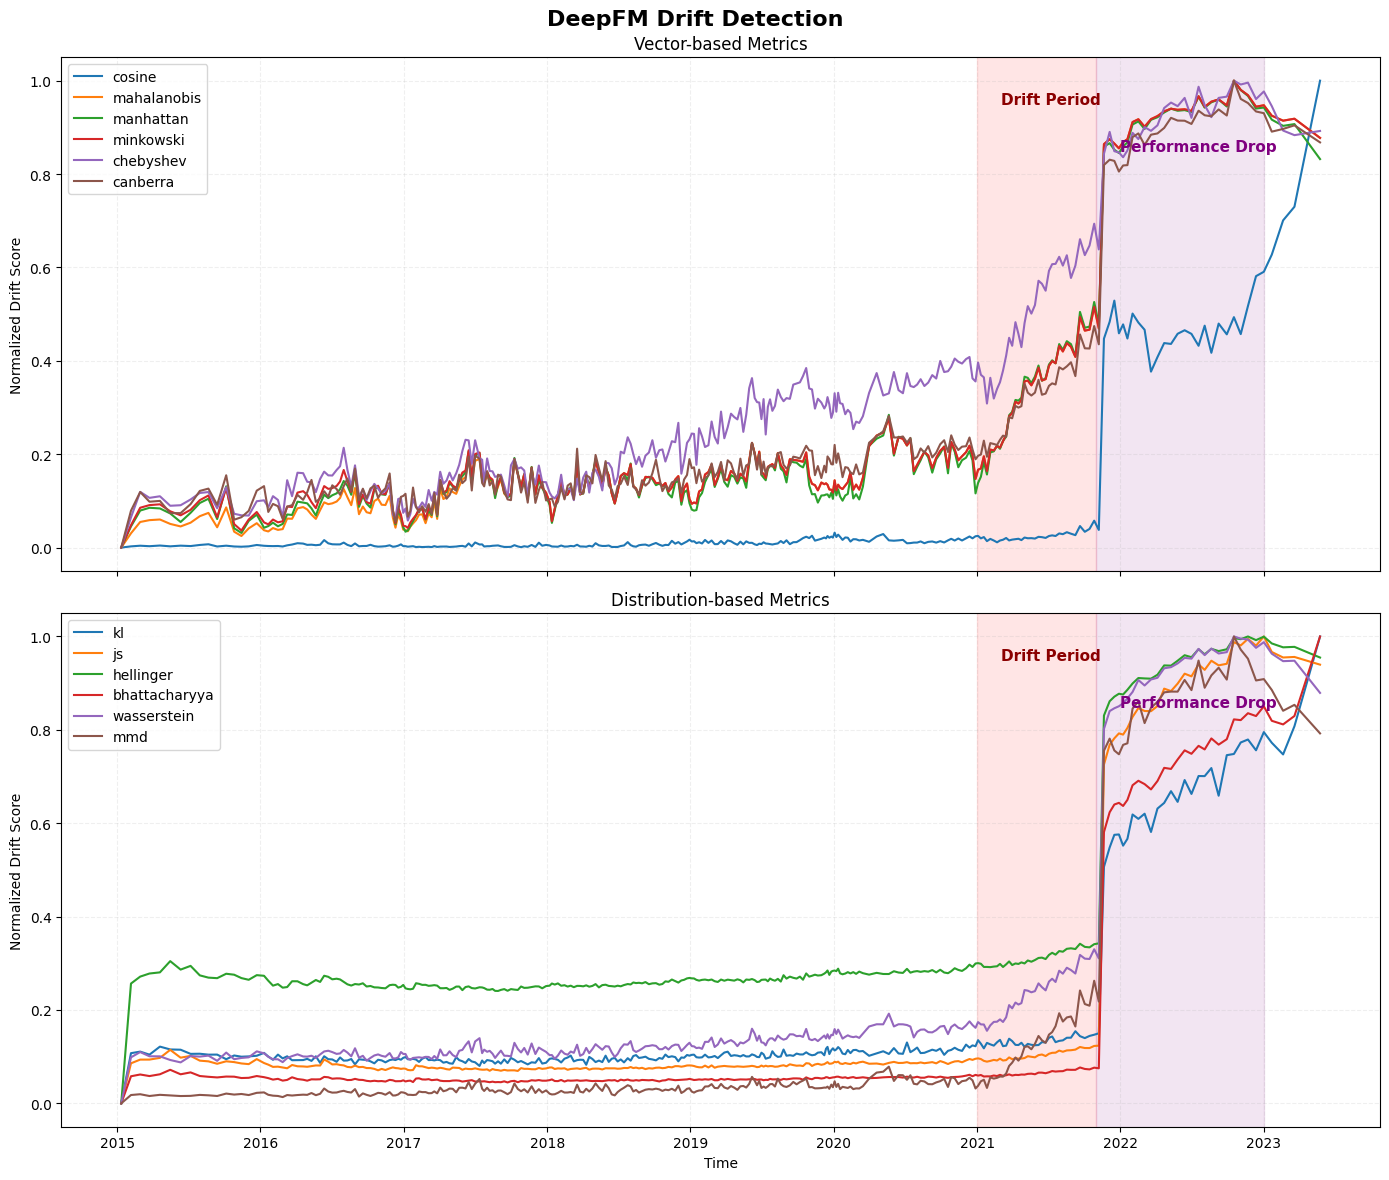

In [15]:
import matplotlib.pyplot as plt

# Make a copy to safely modify
merged_df = combined_df.copy()

# Define merging of histogram and kll into unified labels
merge_map = {
    "kl_kll": "kl",
    "kl_histogram": "kl",
    "js_kll": "js",
    "js_histogram": "js",
    "hellinger_kll": "hellinger",
    "hellinger_histogram": "hellinger",
    "bhattacharyya_kll": "bhattacharyya",
    "bhattacharyya_histogram": "bhattacharyya",
    "wasserstein_kll": "wasserstein",  # no histogram version here
    "mmd_kll": "mmd",  # no histogram version here
}

# Merge method names
merged_df["method"] = merged_df["method"].replace(merge_map)

# Group by method and time, averaging drift values
merged_df = merged_df.groupby(["method", "window_time"], as_index=False).mean()

# Normalize per method
merged_df["normalized_drift"] = merged_df.groupby("method")["drift_distance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Update method categories
vector_methods = [
    "euclidean",
    "cosine",
    "mahalanobis",
    "manhattan",
    "minkowski",
    "chebyshev",
    "canberra",
]
distribution_methods = ["kl", "js", "hellinger", "bhattacharyya", "wasserstein", "mmd"]

# Define time periods for highlighting
drift_start = pd.to_datetime("2021-01-01")
drift_end = pd.to_datetime("2021-11-01")
performance_drop_start = pd.to_datetime("2021-11-01")
performance_drop_end = pd.to_datetime("2023-01-01")

# Set up the plot
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle("DeepFM Drift Detection", fontsize=16, fontweight="bold")

# Panel 1: Vector-based
for method in vector_methods:
    if method in merged_df["method"].unique():
        subset = merged_df[merged_df["method"] == method]
        axs[0].plot(subset["window_time"], subset["normalized_drift"], label=method)

# Add drift period highlighting
axs[0].axvspan(drift_start, drift_end, color="red", alpha=0.1)
axs[0].text(
    drift_start + pd.Timedelta(days=60),
    0.95,
    "Drift Period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)

# Add performance drop highlighting
axs[0].axvspan(performance_drop_start, performance_drop_end, color="purple", alpha=0.1)
axs[0].text(
    performance_drop_start + pd.Timedelta(days=60),
    0.85,
    "Performance Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)

axs[0].set_title("Vector-based Metrics")
axs[0].set_ylabel("Normalized Drift Score")
axs[0].legend()
axs[0].grid(True, linestyle="--", alpha=0.2)

# Panel 2: Distribution-based
for method in distribution_methods:
    if method in merged_df["method"].unique():
        subset = merged_df[merged_df["method"] == method]
        axs[1].plot(subset["window_time"], subset["normalized_drift"], label=method)

# Add drift period highlighting
axs[1].axvspan(drift_start, drift_end, color="red", alpha=0.1)
axs[1].text(
    drift_start + pd.Timedelta(days=60),
    0.95,
    "Drift Period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)

# Add performance drop highlighting
axs[1].axvspan(performance_drop_start, performance_drop_end, color="purple", alpha=0.1)
axs[1].text(
    performance_drop_start + pd.Timedelta(days=60),
    0.85,
    "Performance Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)

axs[1].set_title("Distribution-based Metrics")
axs[1].set_ylabel("Normalized Drift Score")
axs[1].set_xlabel("Time")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.2)

plt.tight_layout()
plt.savefig(
    "drift_detection_results_deepfm.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

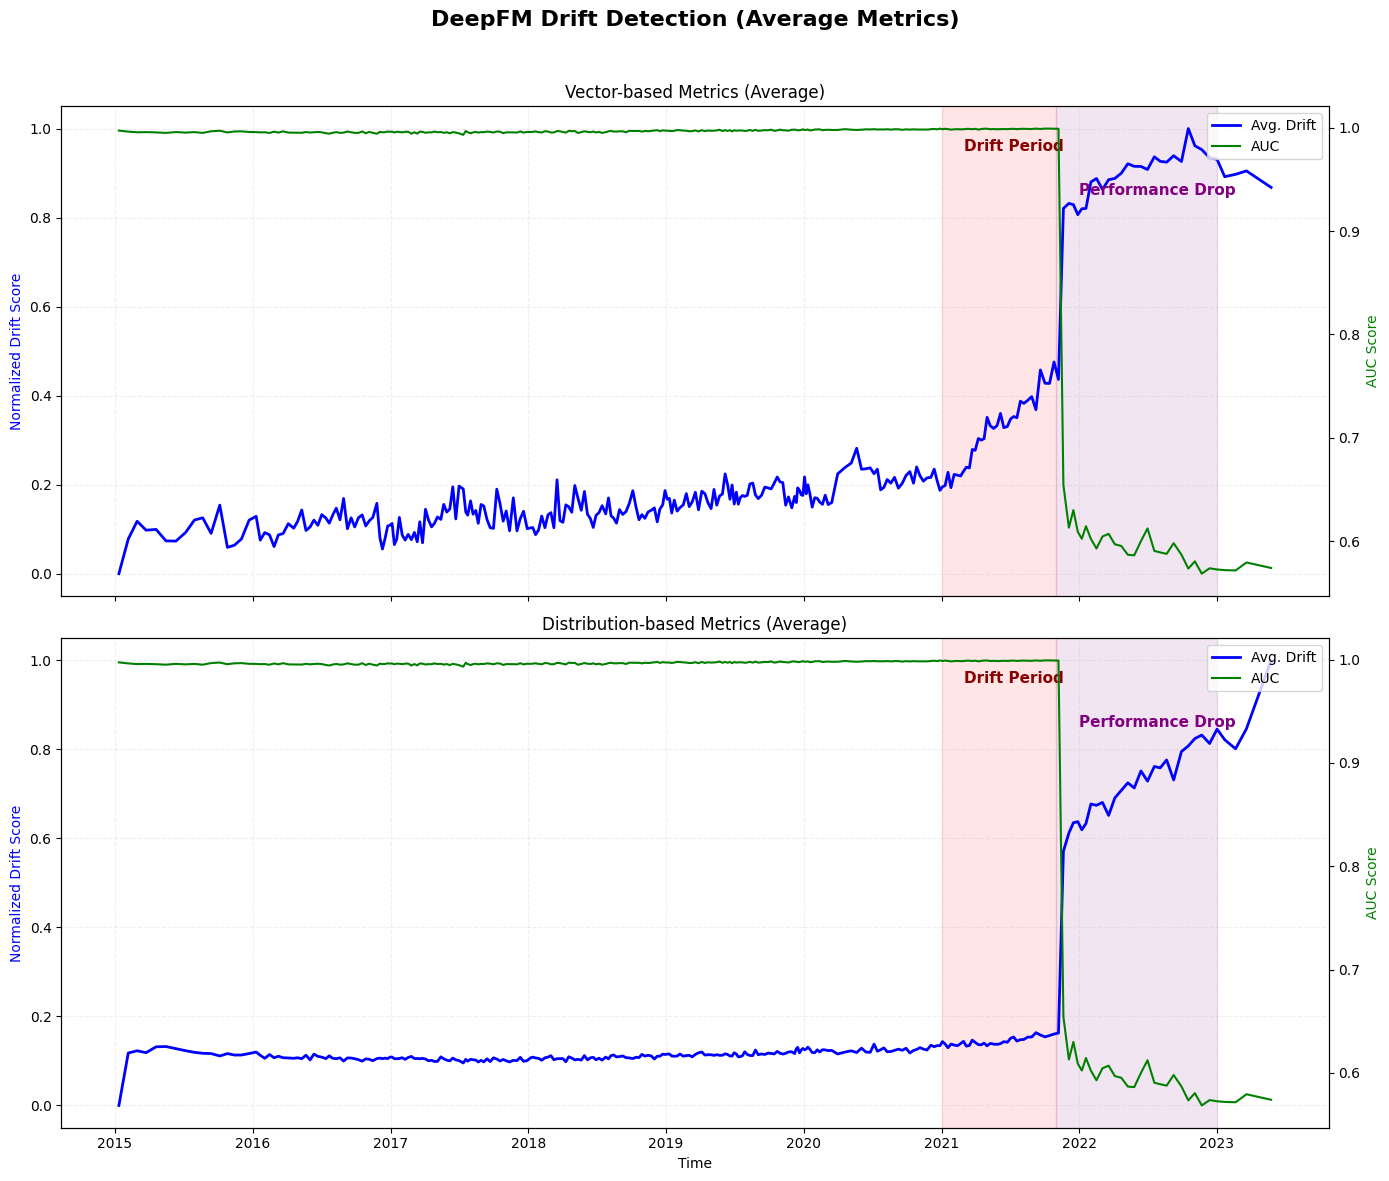

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy to safely modify
merged_df = combined_df.copy()

# Convert timestamp column to datetime if needed
merged_df["window_time"] = pd.to_datetime(merged_df["window_time"])

# Define merging of histogram and kll into unified labels
merge_map = {
    "kl_kll": "kl",
    "kl_histogram": "kl",
    "js_kll": "js",
    "js_histogram": "js",
    "hellinger_kll": "hellinger",
    "hellinger_histogram": "hellinger",
    "bhattacharyya_kll": "bhattacharyya",
    "bhattacharyya_histogram": "bhattacharyya",
    "wasserstein_kll": "wasserstein",
    "mmd_kll": "mmd",
    "mmd_histogram": "mmd",
}

# Merge method names
merged_df["method"] = merged_df["method"].replace(merge_map)

# Update method categories
vector_methods = [
    "euclidean",
    "cosine",
    "mahalanobis",
    "manhattan",
    "minkowski",
    "chebyshev",
    "canberra",
]
distribution_methods = ["kl", "js", "hellinger", "bhattacharyya", "wasserstein", "mmd"]

# Create a method category column
merged_df["category"] = "other"
merged_df.loc[merged_df["method"].isin(vector_methods), "category"] = "vector"
merged_df.loc[merged_df["method"].isin(distribution_methods), "category"] = (
    "distribution"
)

# Group by category and time to calculate average drift scores
avg_drift = (
    merged_df.groupby(["category", "window_time"])["drift_distance"]
    .mean()
    .reset_index()
)

# Group by category and time to calculate average AUC scores
avg_auc = merged_df.groupby(["category", "window_time"])["auc"].mean().reset_index()

# Merge the dataframes
avg_metrics = pd.merge(avg_drift, avg_auc, on=["category", "window_time"])

# Normalize drift values for each category
for category in ["vector", "distribution"]:
    category_data = avg_metrics[avg_metrics["category"] == category]
    min_val = category_data["drift_distance"].min()
    max_val = category_data["drift_distance"].max()
    avg_metrics.loc[avg_metrics["category"] == category, "normalized_drift"] = (
        avg_metrics.loc[avg_metrics["category"] == category, "drift_distance"] - min_val
    ) / (max_val - min_val)

# Define time periods for highlighting
drift_start = pd.to_datetime("2021-01-01")
drift_end = pd.to_datetime("2021-11-01")
performance_drop_start = pd.to_datetime("2021-11-01")
performance_drop_end = pd.to_datetime("2023-01-01")

# Set up the plot
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle("DeepFM Drift Detection (Average Metrics)", fontsize=16, fontweight="bold")

# Get the data for each category
vector_data = avg_metrics[avg_metrics["category"] == "vector"]
dist_data = avg_metrics[avg_metrics["category"] == "distribution"]

# Panel 1: Vector-based metrics average
ax1 = axs[0]
ax1.plot(
    vector_data["window_time"],
    vector_data["normalized_drift"],
    "b-",
    linewidth=2,
    label="Avg. Drift",
)
ax1_twin = ax1.twinx()
ax1_twin.plot(
    vector_data["window_time"], vector_data["auc"], "g-", linewidth=1.5, label="AUC"
)

# Add drift period highlighting
ax1.axvspan(drift_start, drift_end, color="red", alpha=0.1)
ax1.text(
    drift_start + pd.Timedelta(days=60),
    0.95,
    "Drift Period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)

# Add performance drop highlighting
ax1.axvspan(performance_drop_start, performance_drop_end, color="purple", alpha=0.1)
ax1.text(
    performance_drop_start + pd.Timedelta(days=60),
    0.85,
    "Performance Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)

ax1.set_title("Vector-based Metrics (Average)")
ax1.set_ylabel("Normalized Drift Score", color="b")
ax1_twin.set_ylabel("AUC Score", color="g")
ax1.grid(True, linestyle="--", alpha=0.2)

# Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# Panel 2: Distribution-based metrics average
ax2 = axs[1]
ax2.plot(
    dist_data["window_time"],
    dist_data["normalized_drift"],
    "b-",
    linewidth=2,
    label="Avg. Drift",
)
ax2_twin = ax2.twinx()
ax2_twin.plot(
    dist_data["window_time"], dist_data["auc"], "g-", linewidth=1.5, label="AUC"
)

# Add drift period highlighting
ax2.axvspan(drift_start, drift_end, color="red", alpha=0.1)
ax2.text(
    drift_start + pd.Timedelta(days=60),
    0.95,
    "Drift Period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)

# Add performance drop highlighting
ax2.axvspan(performance_drop_start, performance_drop_end, color="purple", alpha=0.1)
ax2.text(
    performance_drop_start + pd.Timedelta(days=60),
    0.85,
    "Performance Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)

ax2.set_title("Distribution-based Metrics (Average)")
ax2.set_ylabel("Normalized Drift Score", color="b")
ax2_twin.set_ylabel("AUC Score", color="g")
ax2.set_xlabel("Time")
ax2.grid(True, linestyle="--", alpha=0.2)

# Add a combined legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.savefig(
    "avg_drift_metrics_comparison.png", dpi=300, bbox_inches="tight", facecolor="white"
)
plt.show()

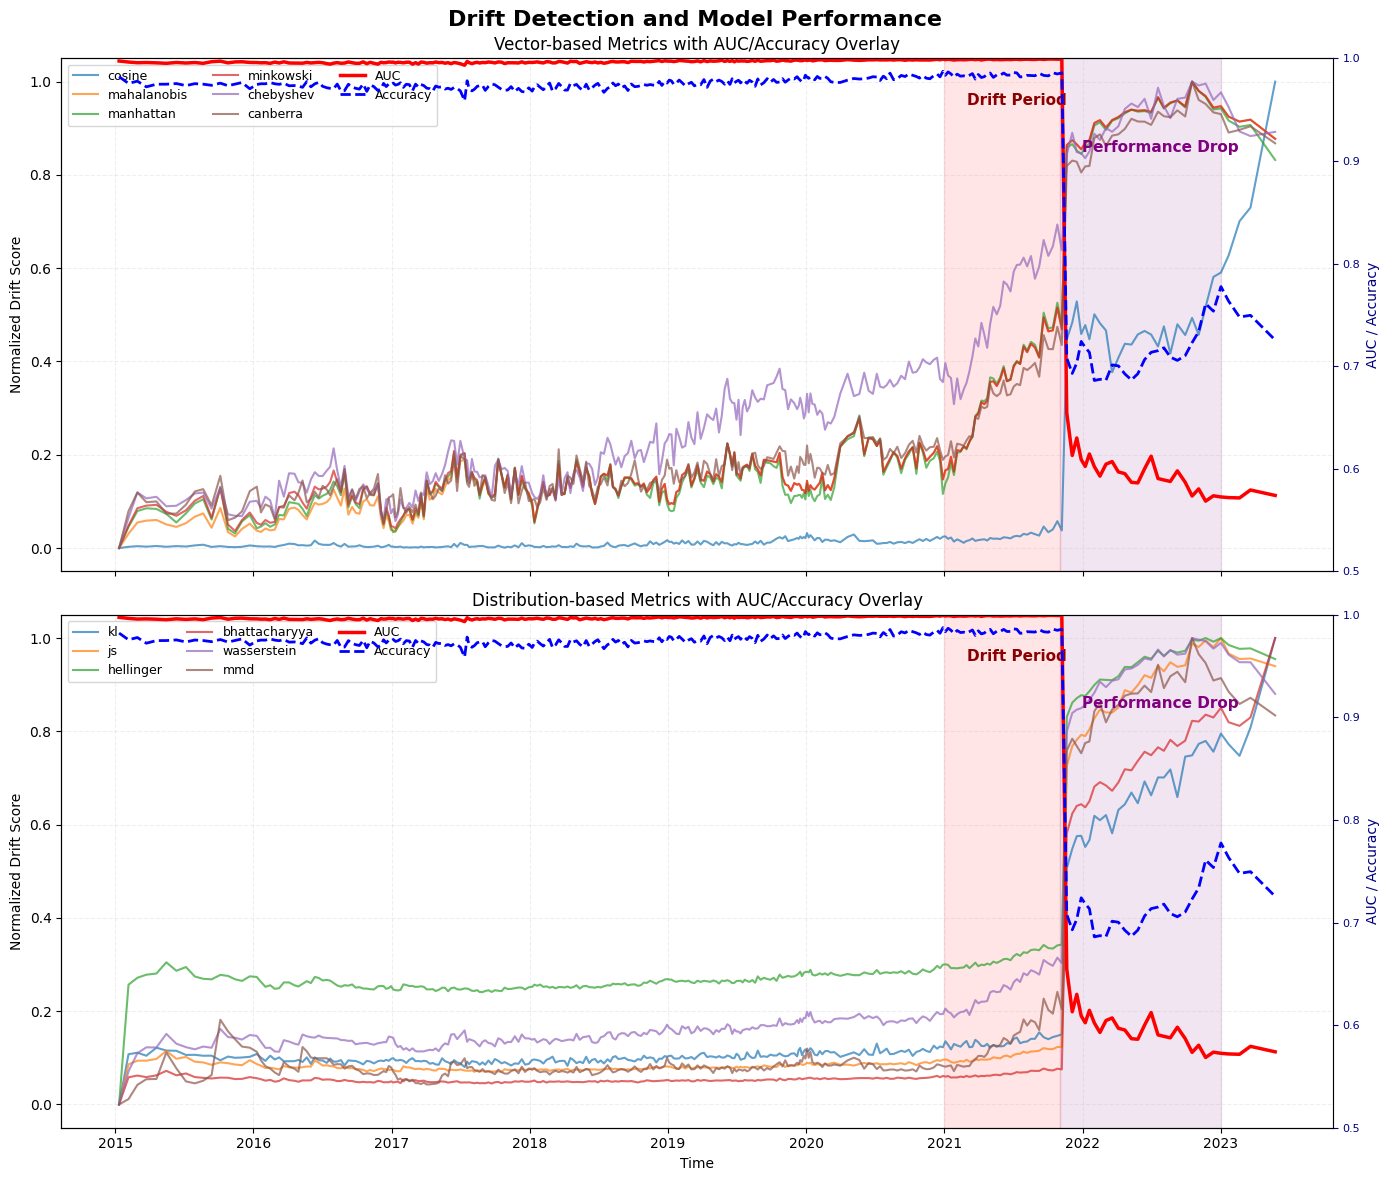

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy to safely modify
merged_df = combined_df.copy()

# Define merging of histogram and kll into unified labels
merge_map = {
    "kl_kll": "kl",
    "kl_histogram": "kl",
    "js_kll": "js",
    "js_histogram": "js",
    "hellinger_kll": "hellinger",
    "hellinger_histogram": "hellinger",
    "bhattacharyya_kll": "bhattacharyya",
    "bhattacharyya_histogram": "bhattacharyya",
    "wasserstein_kll": "wasserstein",
    "wasserstein_histogram": "wasserstein",
    "mmd_kll": "mmd",
    "mmd_histogram": "mmd",
}

# Merge method names
merged_df["method"] = merged_df["method"].replace(merge_map)

# Group by method and time, averaging drift values
grouped_df = merged_df.groupby(["method", "window_time"], as_index=False).mean()

# Normalize per method
grouped_df["normalized_drift"] = grouped_df.groupby("method")[
    "drift_distance"
].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Update method categories
vector_methods = [
    "euclidean",
    "cosine",
    "mahalanobis",
    "manhattan",
    "minkowski",
    "chebyshev",
    "canberra",
]
distribution_methods = ["kl", "js", "hellinger", "bhattacharyya", "wasserstein", "mmd"]

# Define time periods for highlighting
drift_start = pd.to_datetime("2021-01-01")
drift_end = pd.to_datetime("2021-11-01")
performance_drop_start = pd.to_datetime("2021-11-01")
performance_drop_end = pd.to_datetime("2023-01-01")

# Set up a 2-panel plot
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle("Drift Detection and Model Performance", fontsize=16, fontweight="bold")

# Panel 1: Vector-based + Performance overlay
for method in vector_methods:
    if method in grouped_df["method"].unique():
        subset = grouped_df[grouped_df["method"] == method]
        axs[0].plot(
            subset["window_time"], subset["normalized_drift"], label=method, alpha=0.7
        )

# Create secondary y-axis for AUC/Accuracy on first panel
ax_perf1 = axs[0].twinx()
perf_df = merged_df.groupby("window_time", as_index=False)[["accuracy", "auc"]].mean()

# Plot AUC and Accuracy on first panel
(ln_auc1,) = ax_perf1.plot(
    perf_df["window_time"], perf_df["auc"], "r-", linewidth=2.5, label="AUC"
)
(ln_acc1,) = ax_perf1.plot(
    perf_df["window_time"], perf_df["accuracy"], "b--", linewidth=2, label="Accuracy"
)
ax_perf1.set_ylim(0.5, 1.0)
ax_perf1.set_ylabel("AUC / Accuracy", color="navy")
ax_perf1.tick_params(axis="y", colors="navy", labelsize=8)
ax_perf1.spines["right"].set_alpha(0.3)

# Highlight periods on first panel
axs[0].axvspan(drift_start, drift_end, color="red", alpha=0.1)
axs[0].text(
    drift_start + pd.Timedelta(days=60),
    0.95,
    "Drift Period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)
axs[0].axvspan(performance_drop_start, performance_drop_end, color="purple", alpha=0.1)
axs[0].text(
    performance_drop_start + pd.Timedelta(days=60),
    0.85,
    "Performance Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)

# Combined legend for first panel
lns1 = axs[0].get_lines() + [ln_auc1, ln_acc1]
labels1 = [l.get_label() for l in lns1]
axs[0].legend(lns1, labels1, loc="upper left", ncol=3, fontsize=9)

axs[0].set_title("Vector-based Metrics with AUC/Accuracy Overlay")
axs[0].set_ylabel("Normalized Drift Score")
axs[0].grid(True, linestyle="--", alpha=0.2)

# Panel 2: Distribution-based
for method in distribution_methods:
    if method in grouped_df["method"].unique():
        subset = grouped_df[grouped_df["method"] == method]
        axs[1].plot(
            subset["window_time"], subset["normalized_drift"], label=method, alpha=0.7
        )

# Create secondary y-axis for AUC/Accuracy on second panel
ax_perf2 = axs[1].twinx()

# Plot AUC and Accuracy on second panel
(ln_auc2,) = ax_perf2.plot(
    perf_df["window_time"], perf_df["auc"], "r-", linewidth=2.5, label="AUC"
)
(ln_acc2,) = ax_perf2.plot(
    perf_df["window_time"], perf_df["accuracy"], "b--", linewidth=2, label="Accuracy"
)
ax_perf2.set_ylim(0.5, 1.0)
ax_perf2.set_ylabel("AUC / Accuracy", color="navy")
ax_perf2.tick_params(axis="y", colors="navy", labelsize=8)
ax_perf2.spines["right"].set_alpha(0.3)

# Highlight periods on second panel
axs[1].axvspan(drift_start, drift_end, color="red", alpha=0.1)
axs[1].text(
    drift_start + pd.Timedelta(days=60),
    0.95,
    "Drift Period",
    color="darkred",
    fontsize=11,
    fontweight="bold",
)
axs[1].axvspan(performance_drop_start, performance_drop_end, color="purple", alpha=0.1)
axs[1].text(
    performance_drop_start + pd.Timedelta(days=60),
    0.85,
    "Performance Drop",
    color="purple",
    fontsize=11,
    fontweight="bold",
)

# Combined legend for second panel
lns2 = axs[1].get_lines() + [ln_auc2, ln_acc2]
labels2 = [l.get_label() for l in lns2]
axs[1].legend(lns2, labels2, loc="upper left", ncol=3, fontsize=9)

axs[1].set_title("Distribution-based Metrics with AUC/Accuracy Overlay")
axs[1].set_ylabel("Normalized Drift Score")
axs[1].set_xlabel("Time")
axs[1].grid(True, linestyle="--", alpha=0.2)

plt.tight_layout()
plt.savefig(
    "drift_detection_with_auc_overlay.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()